# Source of the data

[Source of the data: Kaggle - Emotions dataset for NLP](https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp)

# Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import tensorflow as tf
import keras

from wordcloud import WordCloud
from PIL import Image
import string

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from sklearn.metrics import confusion_matrix

%matplotlib inline

Using TensorFlow backend.


# Constants

In [2]:
JOY_IMAGE = "C:/Users/JoaoF/Desktop/kaggle_case_studies/Emotions dataset for NLP/joy.png"

# Import txt

In [3]:
train_data = pd.read_csv('train.txt', delimiter=';',header=None)
test_data = pd.read_csv('test.txt', delimiter=';',header=None)
val_data = pd.read_csv('val.txt', delimiter=';',header=None)

In [4]:
train_data.shape

(16000, 2)

In [5]:
test_data.shape

(2000, 2)

In [6]:
val_data.shape

(2000, 2)

In [7]:
df = pd.concat((train_data,test_data,val_data),axis=0,ignore_index=True)
df

,0,1
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
19995,im having ssa examination tomorrow in the morn...,sadness
19996,i constantly worry about their fight against n...,joy
19997,i feel its important to share this info for th...,joy
19998,i truly feel that if you are passionate enough...,joy


In [8]:
df.rename(columns={0: 'Tweet', 1: 'Emotions'},inplace=True)

# Checking for missing data

<AxesSubplot:>

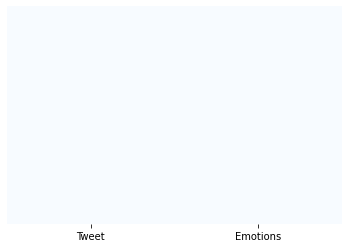

In [9]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [125]:
df['Emotions'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: Emotions, dtype: int64

In [130]:
freq_emotions = df['Emotions'].value_counts()/len(df)

In [131]:
freq_emotions.values

array([0.33805, 0.28985, 0.13545, 0.11865, 0.08205, 0.03595])

In [133]:
conditions = [
    (df['Emotions'] == 'sadness'),
    (df['Emotions'] == 'anger'),
    (df['Emotions'] == 'love'),
    (df['Emotions'] == 'fear'),
    (df['Emotions'] == 'joy'),
    (df['Emotions'] == 'surprise')
    ]

# create a list of the values we want to assign for each condition
values = [freq_emotions.values[1],
          freq_emotions.values[2],
          freq_emotions.values[4],
          freq_emotions.values[3],
          freq_emotions.values[0],
          freq_emotions.values[5]]

# create a new column and use np.select to assign values to it using our lists as arguments
df['Emotions_frequency'] = np.select(conditions, values)

<AxesSubplot:xlabel='Emotions', ylabel='count'>

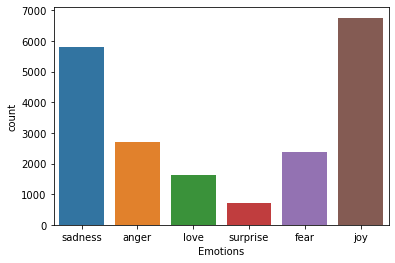

In [137]:
sns.countplot(x = 'Emotions', data = df)

<AxesSubplot:>

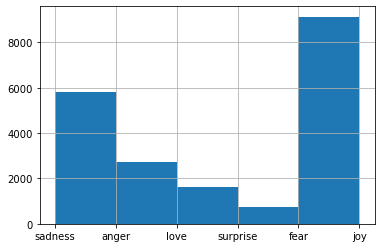

In [138]:
df['Emotions'].hist(bins = 5)

#### There are a lot more emotions classified as sadness and joy rather than anger, love or surprise. This could lead to problems of unbalanced sets. Lets investigate a little more

In [139]:
df['length'] = df['Tweet'].apply(len)
df.head()

,Tweet,Emotions,length,Emotions_frequency
0,i didnt feel humiliated,sadness,23,0.28985
1,i can go from feeling so hopeless to so damned...,sadness,108,0.28985
2,im grabbing a minute to post i feel greedy wrong,anger,48,0.13545
3,i am ever feeling nostalgic about the fireplac...,love,92,0.08205
4,i am feeling grouchy,anger,20,0.13545


<AxesSubplot:ylabel='Frequency'>

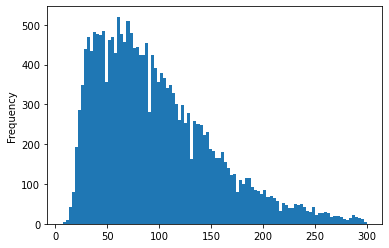

In [140]:
df['length'].plot(bins=100, kind='hist')

In [141]:
df.length.describe()

count    20000.000000
mean        96.670050
std         55.777923
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: length, dtype: float64

In [142]:
# Longest message
df[df['length'] == 300]['Tweet'].iloc[0]

'i hope that those of you who actauly found this and read it feel possibly inspired to go out and buy some of these items or even go through storage and see what clothes of yours your mom saved and that you still have a hope of fitting in and mix up your wardrobe for this summer and have a little fun'

In [143]:
df[df['length'] == 300]['Emotions'].iloc[0]

'joy'

In [144]:
# Shortest Message
short_msg = df[df['length'] == 7]['Tweet'].iloc[0]
short_emotion = df[df['length'] == 7]['Emotions'].iloc[0]

In [145]:
print(f'The smallest tweet is "{short_msg}" and the corresponding emotion is "{short_emotion}" ')

The smallest tweet is "one day" and the corresponding emotion is "sadness" 


# Visualize word cloud per state of emotion

In [146]:
set_emotions = df.Emotions.unique()
range(len(set_emotions))

range(0, 6)

### See 'joy' emotion example

In [147]:
joy_df = df[df['Emotions']=='joy']

In [148]:
#joy_df

In [149]:
joy_df.head()

,Tweet,Emotions,length,Emotions_frequency
8,i have been with petronas for years i feel tha...,joy,98,0.33805
11,i do feel that running is a divine experience ...,joy,108,0.33805
14,i have immense sympathy with the general point...,joy,219,0.33805
15,i do not feel reassured anxiety is on each side,joy,47,0.33805
22,i have the feeling she was amused and delighted,joy,47,0.33805


In [150]:
sentences = joy_df['Tweet'].tolist()
len(sentences)

6761

In [151]:
# print(sentences)

['i have been with petronas for years i feel that petronas has performed well and made a huge profit', 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter', 'i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a little precious', 'i do not feel reassured anxiety is on each side', 'i have the feeling she was amused and delighted', 'i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me', 'i feel more superior dead chicken or grieving child', 'i get giddy over feeling elegant in a perfectly fitted pencil skirt', 'i can t imagine a real life scenario where i would be emotionally connected enough with someone to feel totally accepted and safe where it it morally acceptable for me to have close and prolonged phys

In [152]:
sentences_as_one_string =" ".join(sentences)

(-0.5, 399.5, 199.5, -0.5)

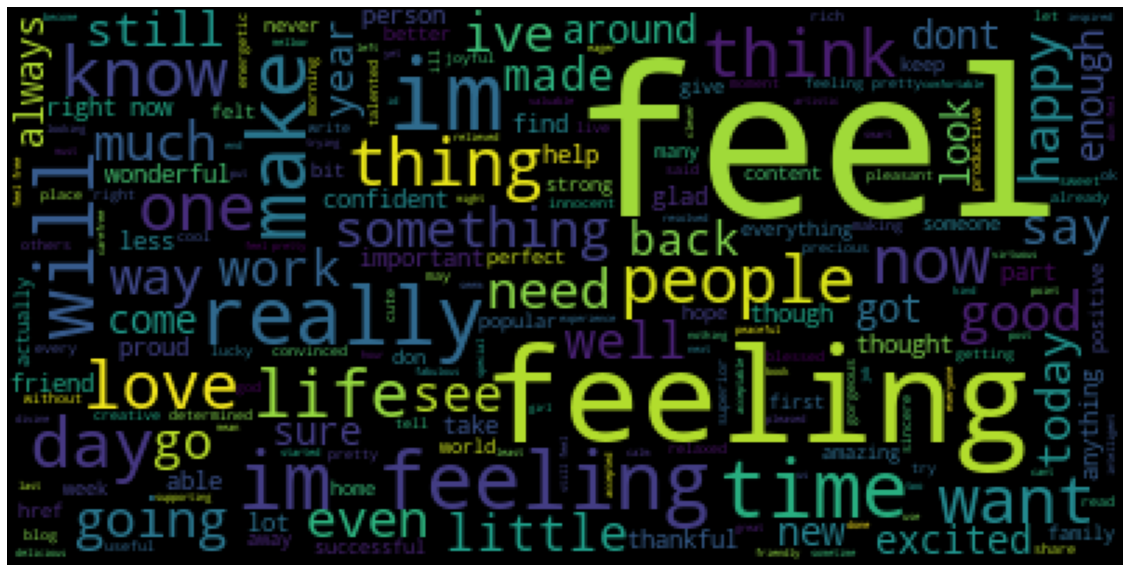

In [153]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))
plt.axis('off')

### Visualize all the emotions

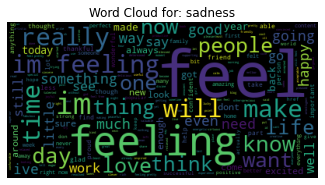

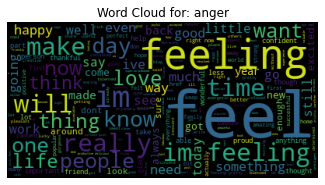

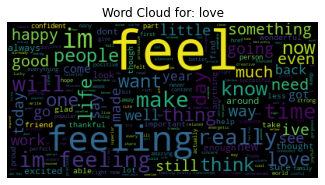

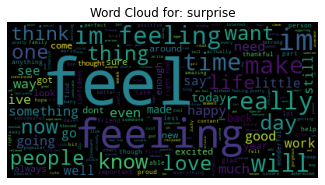

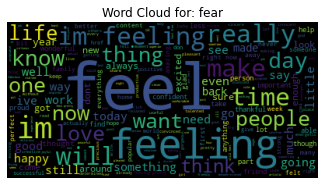

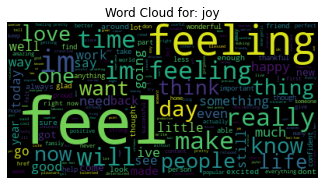

In [154]:
for i in range(1,len(set_emotions)+1):
    setences = df[df['Emotions']==set_emotions[i-1]]['Tweet'].tolist()
    sentences_as_one_string =" ".join(sentences)
    plt.figure(figsize=(20,20))
    plt.subplot(len(set_emotions),1,i)
    plt.imshow(WordCloud().generate(sentences_as_one_string))
    plt.axis('off')
    plt.title(f'Word Cloud for: {set_emotions[i-1]}')

### It is observed that feel, feeling words are very often written in all states of emotions. Lets procced to the removal of punctuation, stop words and apply the tokenization

# Remove possible punctuation, stop words and perform count vectorization - Trial on coments classified as joy

In [155]:
stop_words = set(stopwords.words('english'))

In [156]:
stop_words.add('im') # this is a common abbreviation word found in the world cloud thus it should be added to the stop words as it represents I am

In [157]:
if "im" in stop_words: 
    print('Found it!') 
else: 
    print('Not in here')

Found it!


In [158]:
# Example:
tweet = "I feel very sad about this situation at my place, thus im gonna try to change it!"
words = word_tokenize(tweet.lower())
remove_noise = []
for word in words:
    if word not in stop_words:
        remove_noise.append(word)
print(remove_noise)

['feel', 'sad', 'situation', 'place', ',', 'thus', 'gon', 'na', 'try', 'change', '!']


### word stems and stemming to remove all the affixes (e.g. feel and feeling) and remove the punctuation

In [159]:
tweet = "I feel , feeling very sad about this situation at my place, thus im going to try, tries, tried, trying to change it!"

words = word_tokenize(tweet.lower())
stemmer = SnowballStemmer('english')

remove_noise = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        remove_noise.append(stemmed_word)
print(remove_noise)

['feel', 'feel', 'sad', 'situat', 'place', 'thus', 'go', 'tri', 'tri', 'tri', 'tri', 'chang']


### Definition of a function to apply to remove stop words, word steming and remove punctuation

In [160]:
def clean_tweet(tweet, stemmer = PorterStemmer(), stop_words=set(stopwords.words('english'))):
    words = word_tokenize(tweet.lower())
    filtered_words= []
    for word in words:
        if word not in stop_words and word.isalpha() and word not in 'im' and word not in 'didnt' and word not in 'feel':
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [161]:
# Slice of the dataset to try the function
test_func = joy_df.Tweet.iloc[0:3]
test_func

8     i have been with petronas for years i feel tha...
11    i do feel that running is a divine experience ...
14    i have immense sympathy with the general point...
Name: Tweet, dtype: object

In [162]:
test_nonoise = test_func.apply(clean_tweet)
test_nonoise

8     [petrona, year, petrona, perform, well, made, ...
11    [run, divin, experi, expect, type, spiritu, en...
14    [immens, sympathi, gener, point, possibl, prot...
Name: Tweet, dtype: object

In [163]:
joy_df_nonoise = joy_df.Tweet.apply(clean_tweet)

In [164]:
joy_df_nonoise.values[1]

['run', 'divin', 'experi', 'expect', 'type', 'spiritu', 'encount']

In [165]:
flat_joy_df = [item for sublist in joy_df_nonoise for item in sublist]
normal_words = pd.Series(flat_joy_df).value_counts()

normal_words.shape[0]

6912

In [166]:
normal_words.head(10)

feel      2204
like      1279
make       465
time       417
get        403
go         394
realli     377
know       349
want       332
love       322
dtype: int64

# Word Cloud

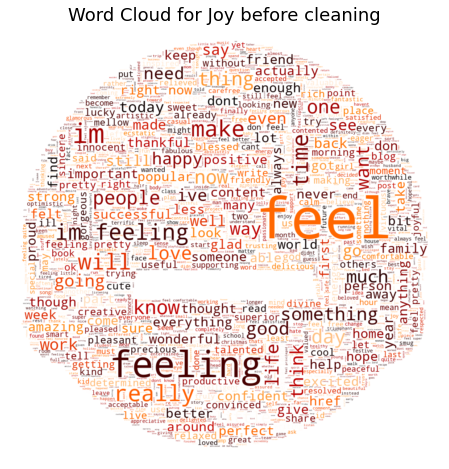

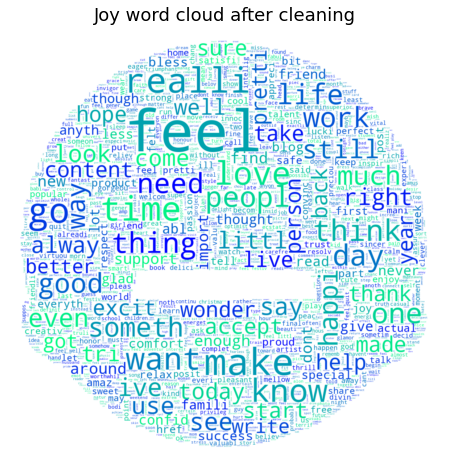

In [167]:
icon = Image.open(JOY_IMAGE)
image_mask = Image.new(mode='RGB',size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)
word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=2000,colormap='gist_heat')
setences = df[df['Emotions']=='Joy']['Tweet'].tolist()
sentences_as_one_string =" ".join(sentences)
word_cloud.generate(sentences_as_one_string)
plt.figure(figsize=(12,8))
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.title(f'Word Cloud for Joy before cleaning',fontsize=18)
plt.show()


word_cloud = WordCloud(mask=rgb_array,max_words=2000,colormap='winter',background_color='white')
setence_joy = ' '.join(flat_joy_df)
word_cloud.generate(setence_joy)
plt.figure(figsize=(12,8))
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Joy word cloud after cleaning',fontsize=18)
plt.show()

### Count Vectorizer, see occurencies of the words


In [168]:
## Count Vectorizer, see occurencies of the words
sample_data = ['I am going home, he has to.','im I am going hom two two times.','I am going home three three three times.','I am going home four four four four times']

vectorizer = CountVectorizer(stop_words='english',analyzer=clean_tweet)
X = vectorizer.fit_transform(sample_data)


In [169]:
print(vectorizer.get_feature_names())

['four', 'go', 'hom', 'home', 'three', 'time', 'two']


In [170]:
print(X.toarray())

[[0 1 0 1 0 0 0]
 [0 1 1 0 0 1 2]
 [0 1 0 1 3 1 0]
 [4 1 0 1 0 1 0]]


In [171]:
vectorizer = CountVectorizer(stop_words='english', analyzer = clean_tweet)
reviews_countvectorizer = vectorizer.fit_transform(joy_df.Tweet)

In [172]:
# print(vectorizer.get_feature_names())

['aaaaaaand', 'aaaah', 'aaaand', 'ab', 'abandon', 'abat', 'abc', 'abdomen', 'abelard', 'abid', 'abil', 'abl', 'abomin', 'abound', 'abraham', 'abroad', 'absenc', 'absolut', 'absolutli', 'absorb', 'absorpt', 'abstain', 'abstin', 'abstract', 'absurd', 'abund', 'abus', 'academ', 'acaus', 'accent', 'accept', 'access', 'accessori', 'accident', 'acco', 'accommod', 'accompani', 'accomplish', 'accord', 'account', 'accumul', 'accur', 'accus', 'ach', 'acheiv', 'achiev', 'acim', 'acker', 'acknowledg', 'aconfid', 'acquaint', 'acquir', 'across', 'act', 'actauli', 'action', 'activ', 'activist', 'actor', 'actress', 'actual', 'ad', 'adapt', 'add', 'addict', 'addison', 'addit', 'address', 'ade', 'adequ', 'adher', 'adjust', 'administr', 'admir', 'admiss', 'admit', 'admitt', 'adopt', 'ador', 'adrenalin', 'adult', 'advanc', 'advantag', 'adventur', 'advertis', 'advic', 'advis', 'advoc', 'advocaci', 'aesthet', 'afar', 'affair', 'affect', 'affection', 'affend', 'affili', 'affirm', 'afford', 'afghan', 'afield'

In [173]:
print(reviews_countvectorizer.toarray()) 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [174]:
reviews_countvectorizer.shape

(6761, 6912)

# Lets now apply for all state emotions

In [175]:
df

,Tweet,Emotions,length,Emotions_frequency
0,i didnt feel humiliated,sadness,23,0.28985
1,i can go from feeling so hopeless to so damned...,sadness,108,0.28985
2,im grabbing a minute to post i feel greedy wrong,anger,48,0.13545
3,i am ever feeling nostalgic about the fireplac...,love,92,0.08205
4,i am feeling grouchy,anger,20,0.13545
...,...,...,...,...
19995,im having ssa examination tomorrow in the morn...,sadness,191,0.28985
19996,i constantly worry about their fight against n...,joy,173,0.33805
19997,i feel its important to share this info for th...,joy,80,0.33805
19998,i truly feel that if you are passionate enough...,joy,105,0.33805


In [176]:
df_nonoise = df.Tweet.apply(clean_tweet)

In [177]:
df_nonoise

0                                                 [humili]
1        [go, feel, hopeless, damn, hope, around, someo...
2                       [grab, minut, post, greedi, wrong]
3        [ever, feel, nostalg, fireplac, know, still, p...
4                                          [feel, grouchi]
                               ...                        
19995    [ssa, examin, tomorrow, morn, quit, well, prep...
19996    [constantli, worri, fight, natur, push, limit,...
19997                 [import, share, info, experi, thing]
19998    [truli, passion, enough, someth, stay, true, s...
19999    [like, wan, na, buy, cute, make, see, onlin, e...
Name: Tweet, Length: 20000, dtype: object

In [178]:
flat_df = [item for sublist in df_nonoise for item in sublist]
normal_words = pd.Series(flat_df).value_counts()

normal_words.shape[0]

11585

In [179]:
normal_words.head(10)

feel      7266
like      3760
get       1228
time      1215
know      1192
realli    1182
make      1144
go        1101
want      1064
love       988
dtype: int64

In [180]:
vectorizer = CountVectorizer(stop_words='english', analyzer = clean_tweet)
tweets_countvectorizer = vectorizer.fit_transform(df.Tweet)

In [181]:
tweets_countvectorizer.shape

(20000, 11585)

In [182]:
# vectorizer.vocabulary_

{'humili': 4812,
 'go': 4184,
 'feel': 3600,
 'hopeless': 4742,
 'damn': 2373,
 'hope': 4740,
 'around': 509,
 'someon': 9378,
 'care': 1470,
 'awak': 668,
 'grab': 4236,
 'minut': 6436,
 'post': 7768,
 'greedi': 4284,
 'wrong': 11439,
 'ever': 3378,
 'nostalg': 6939,
 'fireplac': 3695,
 'know': 5595,
 'still': 9658,
 'properti': 7951,
 'grouchi': 4316,
 'ive': 5268,
 'littl': 5898,
 'burden': 1335,
 'late': 5685,
 'wasnt': 11146,
 'sure': 9872,
 'take': 9981,
 'milligram': 6406,
 'time': 10267,
 'recommend': 8239,
 'amount': 336,
 'fallen': 3527,
 'asleep': 554,
 'lot': 5980,
 'faster': 3560,
 'also': 289,
 'like': 5848,
 'funni': 3988,
 'confus': 2029,
 'life': 5831,
 'teenag': 10066,
 'jade': 5284,
 'year': 11492,
 'old': 7066,
 'man': 6130,
 'petrona': 7528,
 'perform': 7478,
 'well': 11209,
 'made': 6074,
 'huge': 4797,
 'profit': 7925,
 'romant': 8561,
 'make': 6107,
 'suffer': 9811,
 'see': 8864,
 'mean': 6266,
 'someth': 9380,
 'run': 8626,
 'divin': 2828,
 'experi': 3454,
 'ex

In [183]:
tweets = pd.DataFrame(tweets_countvectorizer.toarray())

In [184]:
tweets 

,0,1,2,3,4,5,6,7,8,9,...,11575,11576,11577,11578,11579,11580,11581,11582,11583,11584
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [223]:
final_df = pd.concat([tweets, df['Emotions']],axis=1)
final_df

,0,1,2,3,4,5,6,7,8,9,...,11576,11577,11578,11579,11580,11581,11582,11583,11584,Emotions
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,sadness
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,sadness
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,anger
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,love
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,sadness
19996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,joy
19997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,joy
19998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,joy


In [224]:
conditions = [
    (final_df['Emotions'] == 'sadness'),
    (final_df['Emotions'] == 'anger'),
    (final_df['Emotions'] == 'love'),
    (final_df['Emotions'] == 'fear'),
    (final_df['Emotions'] == 'joy'),
    (final_df['Emotions'] == 'surprise')
    ]

# create a list of the values we want to assign for each condition
values = [0,1,2,3,4,5]

# create a new column and use np.select to assign values to it using our lists as arguments
final_df['Emotions_value'] = np.select(conditions, values)

In [225]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,11577,11578,11579,11580,11581,11582,11583,11584,Emotions,Emotions_value
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,sadness,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,sadness,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,anger,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,love,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,anger,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,sadness,0
19996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,joy,4
19997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,joy,4
19998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,joy,4


In [226]:
final_df.drop(['Emotions'],axis=1,inplace=True)

In [227]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,11576,11577,11578,11579,11580,11581,11582,11583,11584,Emotions_value
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
19997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
19998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


# Train test split

In [228]:
X=final_df.loc[:, final_df.columns != 'Emotions_value']
y=final_df['Emotions_value']

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size=0.3, random_state=101)

In [230]:
X_train.shape

(14000, 11585)

In [231]:
y_train.shape

(14000,)

# Train and evaluate a random forest classifier

In [232]:
model = RandomForestClassifier(criterion='entropy')
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

## Confusion Matrix for test

In [233]:
def plot_cm(cm, resolution, labels,NR_CLASSES=6):
    plt.figure(figsize=(10,10), dpi=resolution)
    plt.imshow(cm, cmap=plt.cm.Greens)
    plt.title("Confusion Matrix", fontsize=16)
    plt.ylabel("Actual Labels", fontsize=12)
    plt.xlabel("Predicted Labels", fontsize=12)

    tick_marks = np.arange(NR_CLASSES)
    plt.yticks(tick_marks, labels)
    plt.xticks(tick_marks, labels)

    plt.colorbar()

    for i, j in itertools.product(range(NR_CLASSES),range(NR_CLASSES)):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
            color='white' if cm[i,j]>1000 else 'black')
    return plt.show()

In [234]:
cm = confusion_matrix(y_test, model.predict(X_test))
cm.shape

(6, 6)

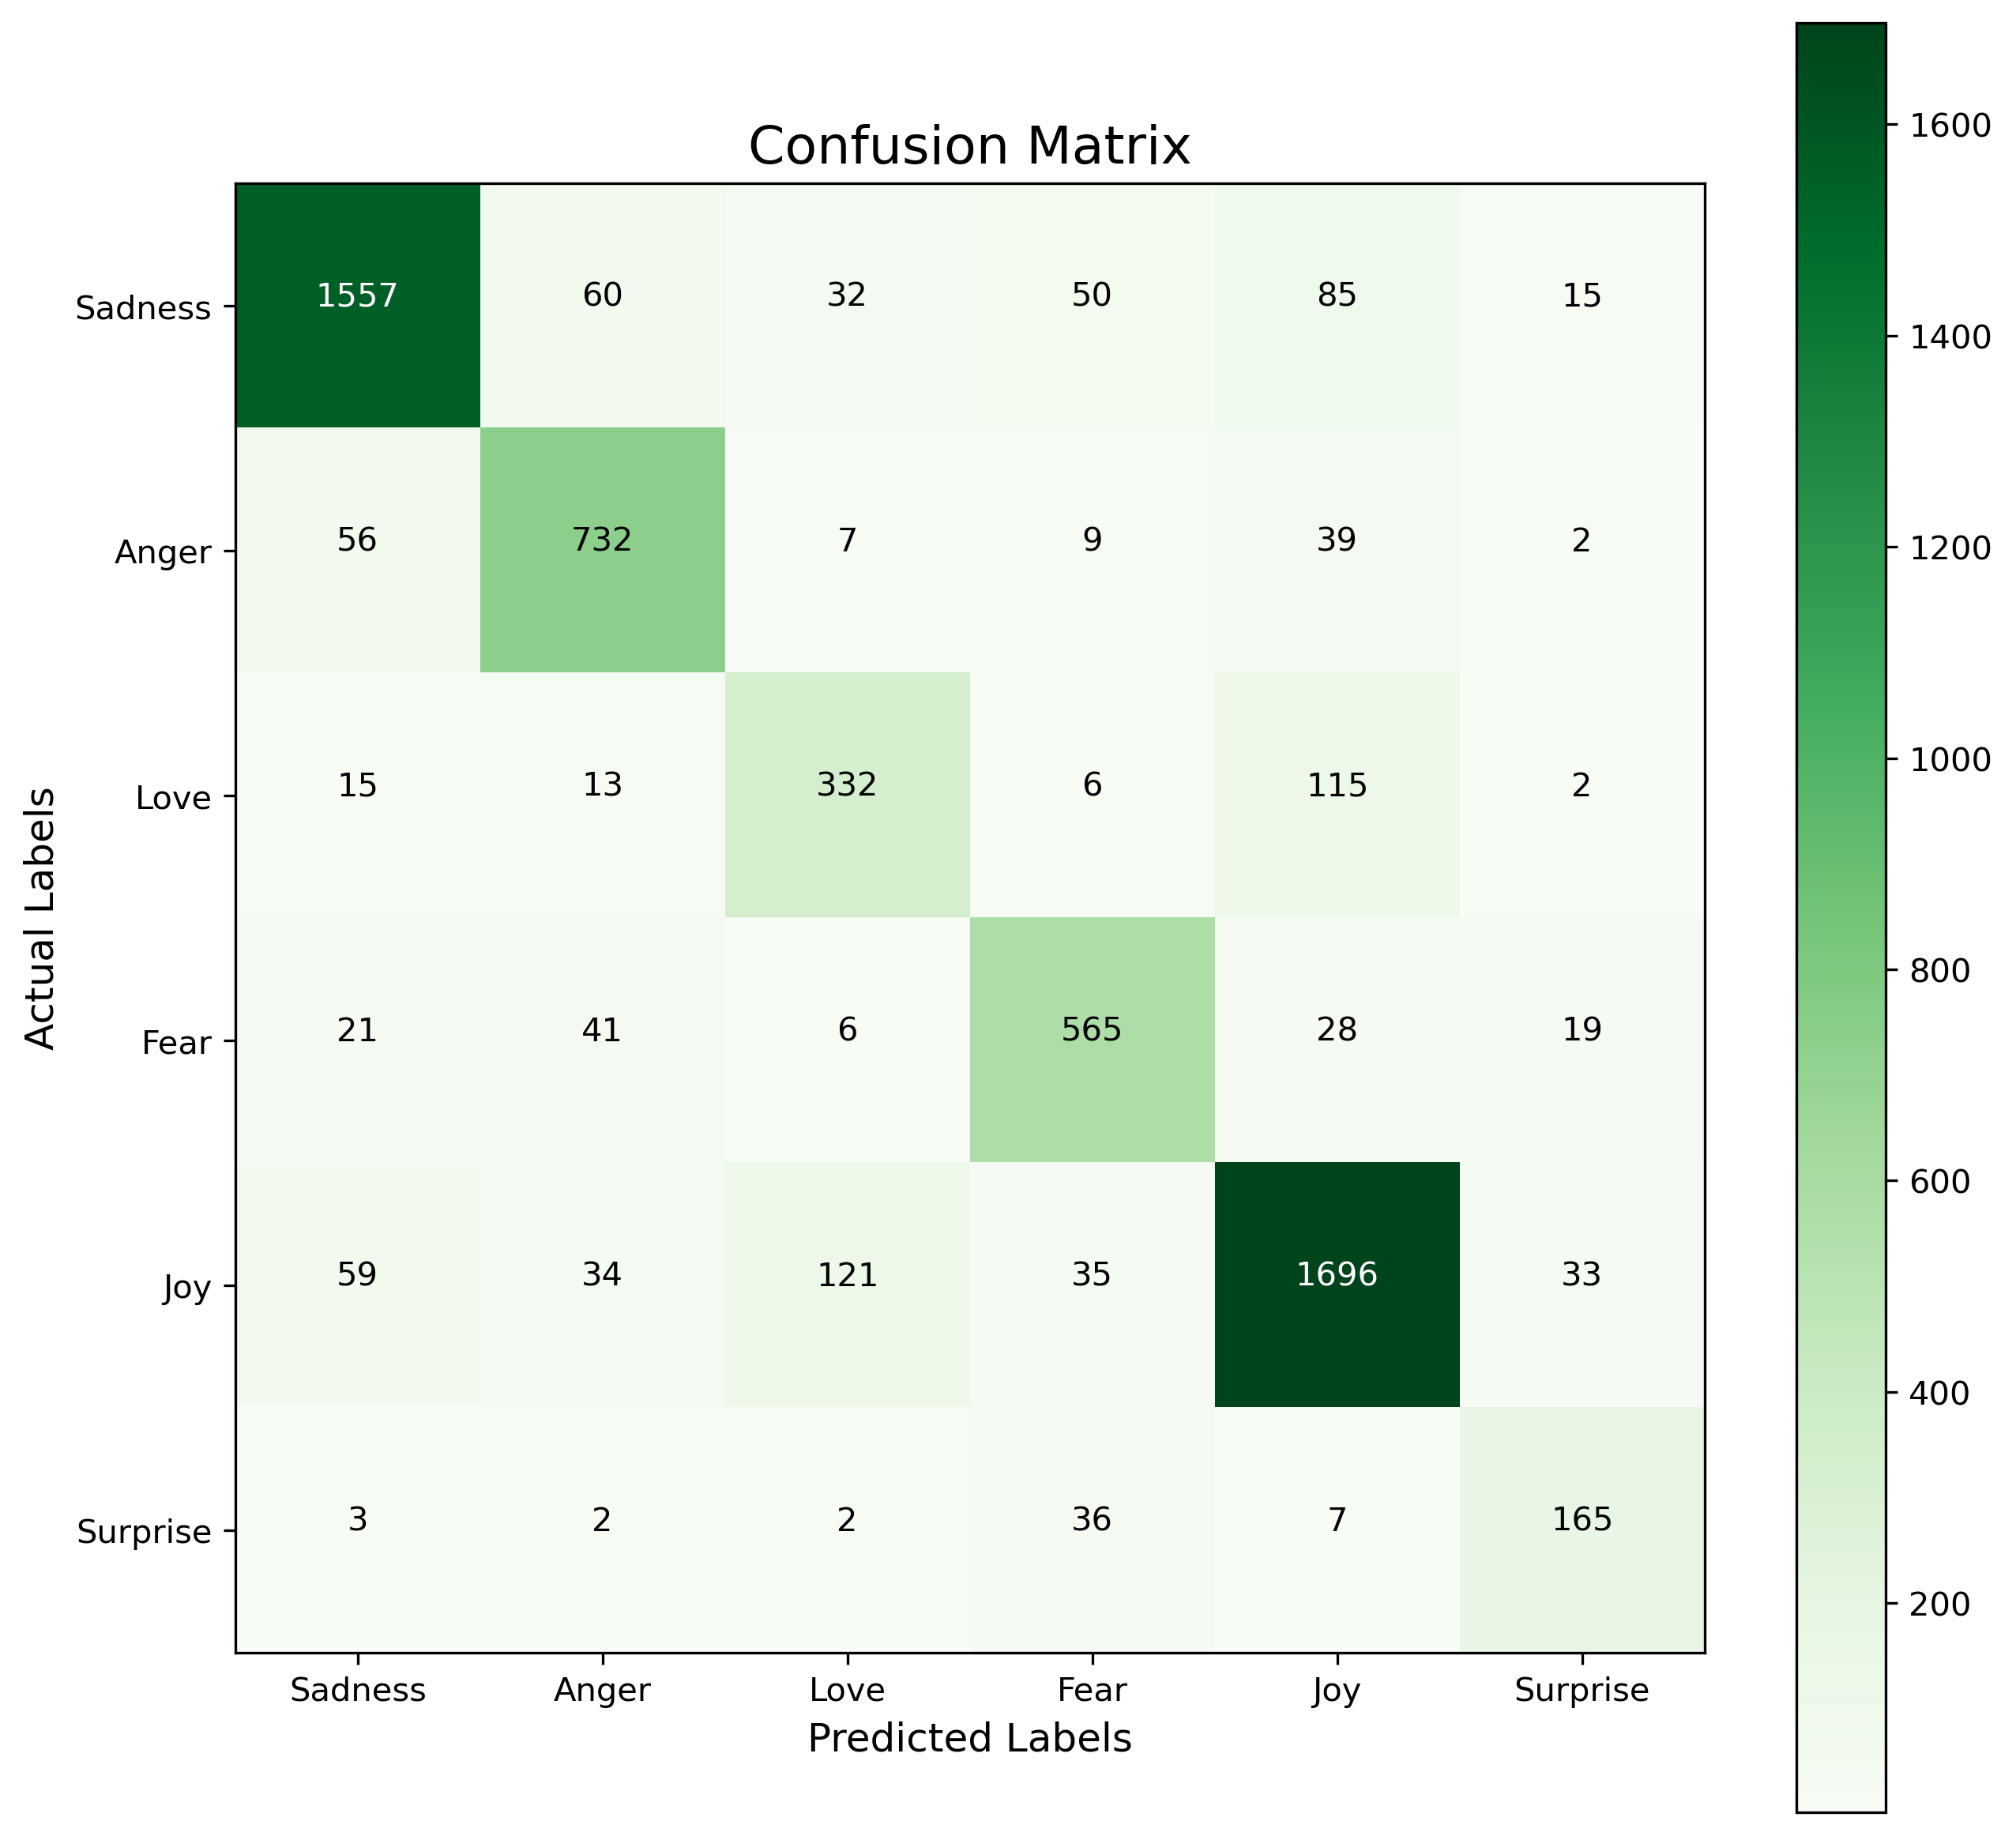

In [235]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)

In [236]:
def stats(cm):
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    avg_recall = np.mean(recall)
    avg_precision = np.mean(precision)
    f1_score = 2*(avg_recall*avg_precision) / (avg_precision + avg_recall)
    
    return f'Model recall score is {avg_recall:.2%}', f'Model precision score is {avg_precision:.2%}', f'Model f1 score is {f1_score:.2%}'
    

In [237]:
stats(cm)

('Model recall score is 81.25%',
 'Model precision score is 79.50%',
 'Model f1 score is 80.36%')

In [238]:
EXAMPLE = ['I am glad to have you here with me',
          'Those people were arrested without making any sense. This is ridiculous!!!! Shame to this!!!',
          'This sunset is amazing!!',
          'There is no shame in this government making this kinds of decisions. I am afraid we are going to be in a very difficult situation in the future']

In [239]:
matrix=vectorizer.transform(EXAMPLE)
matrix.shape

(4, 11585)

In [240]:
model.predict(matrix)

array([4, 0, 5, 3])

# Train and evaluate a naive bayes model

In [241]:
NB = MultinomialNB()
NB.fit(X_train,y_train)

MultinomialNB()

In [242]:
cm = confusion_matrix(y_test, NB.predict(X_test))
cm.shape

(6, 6)

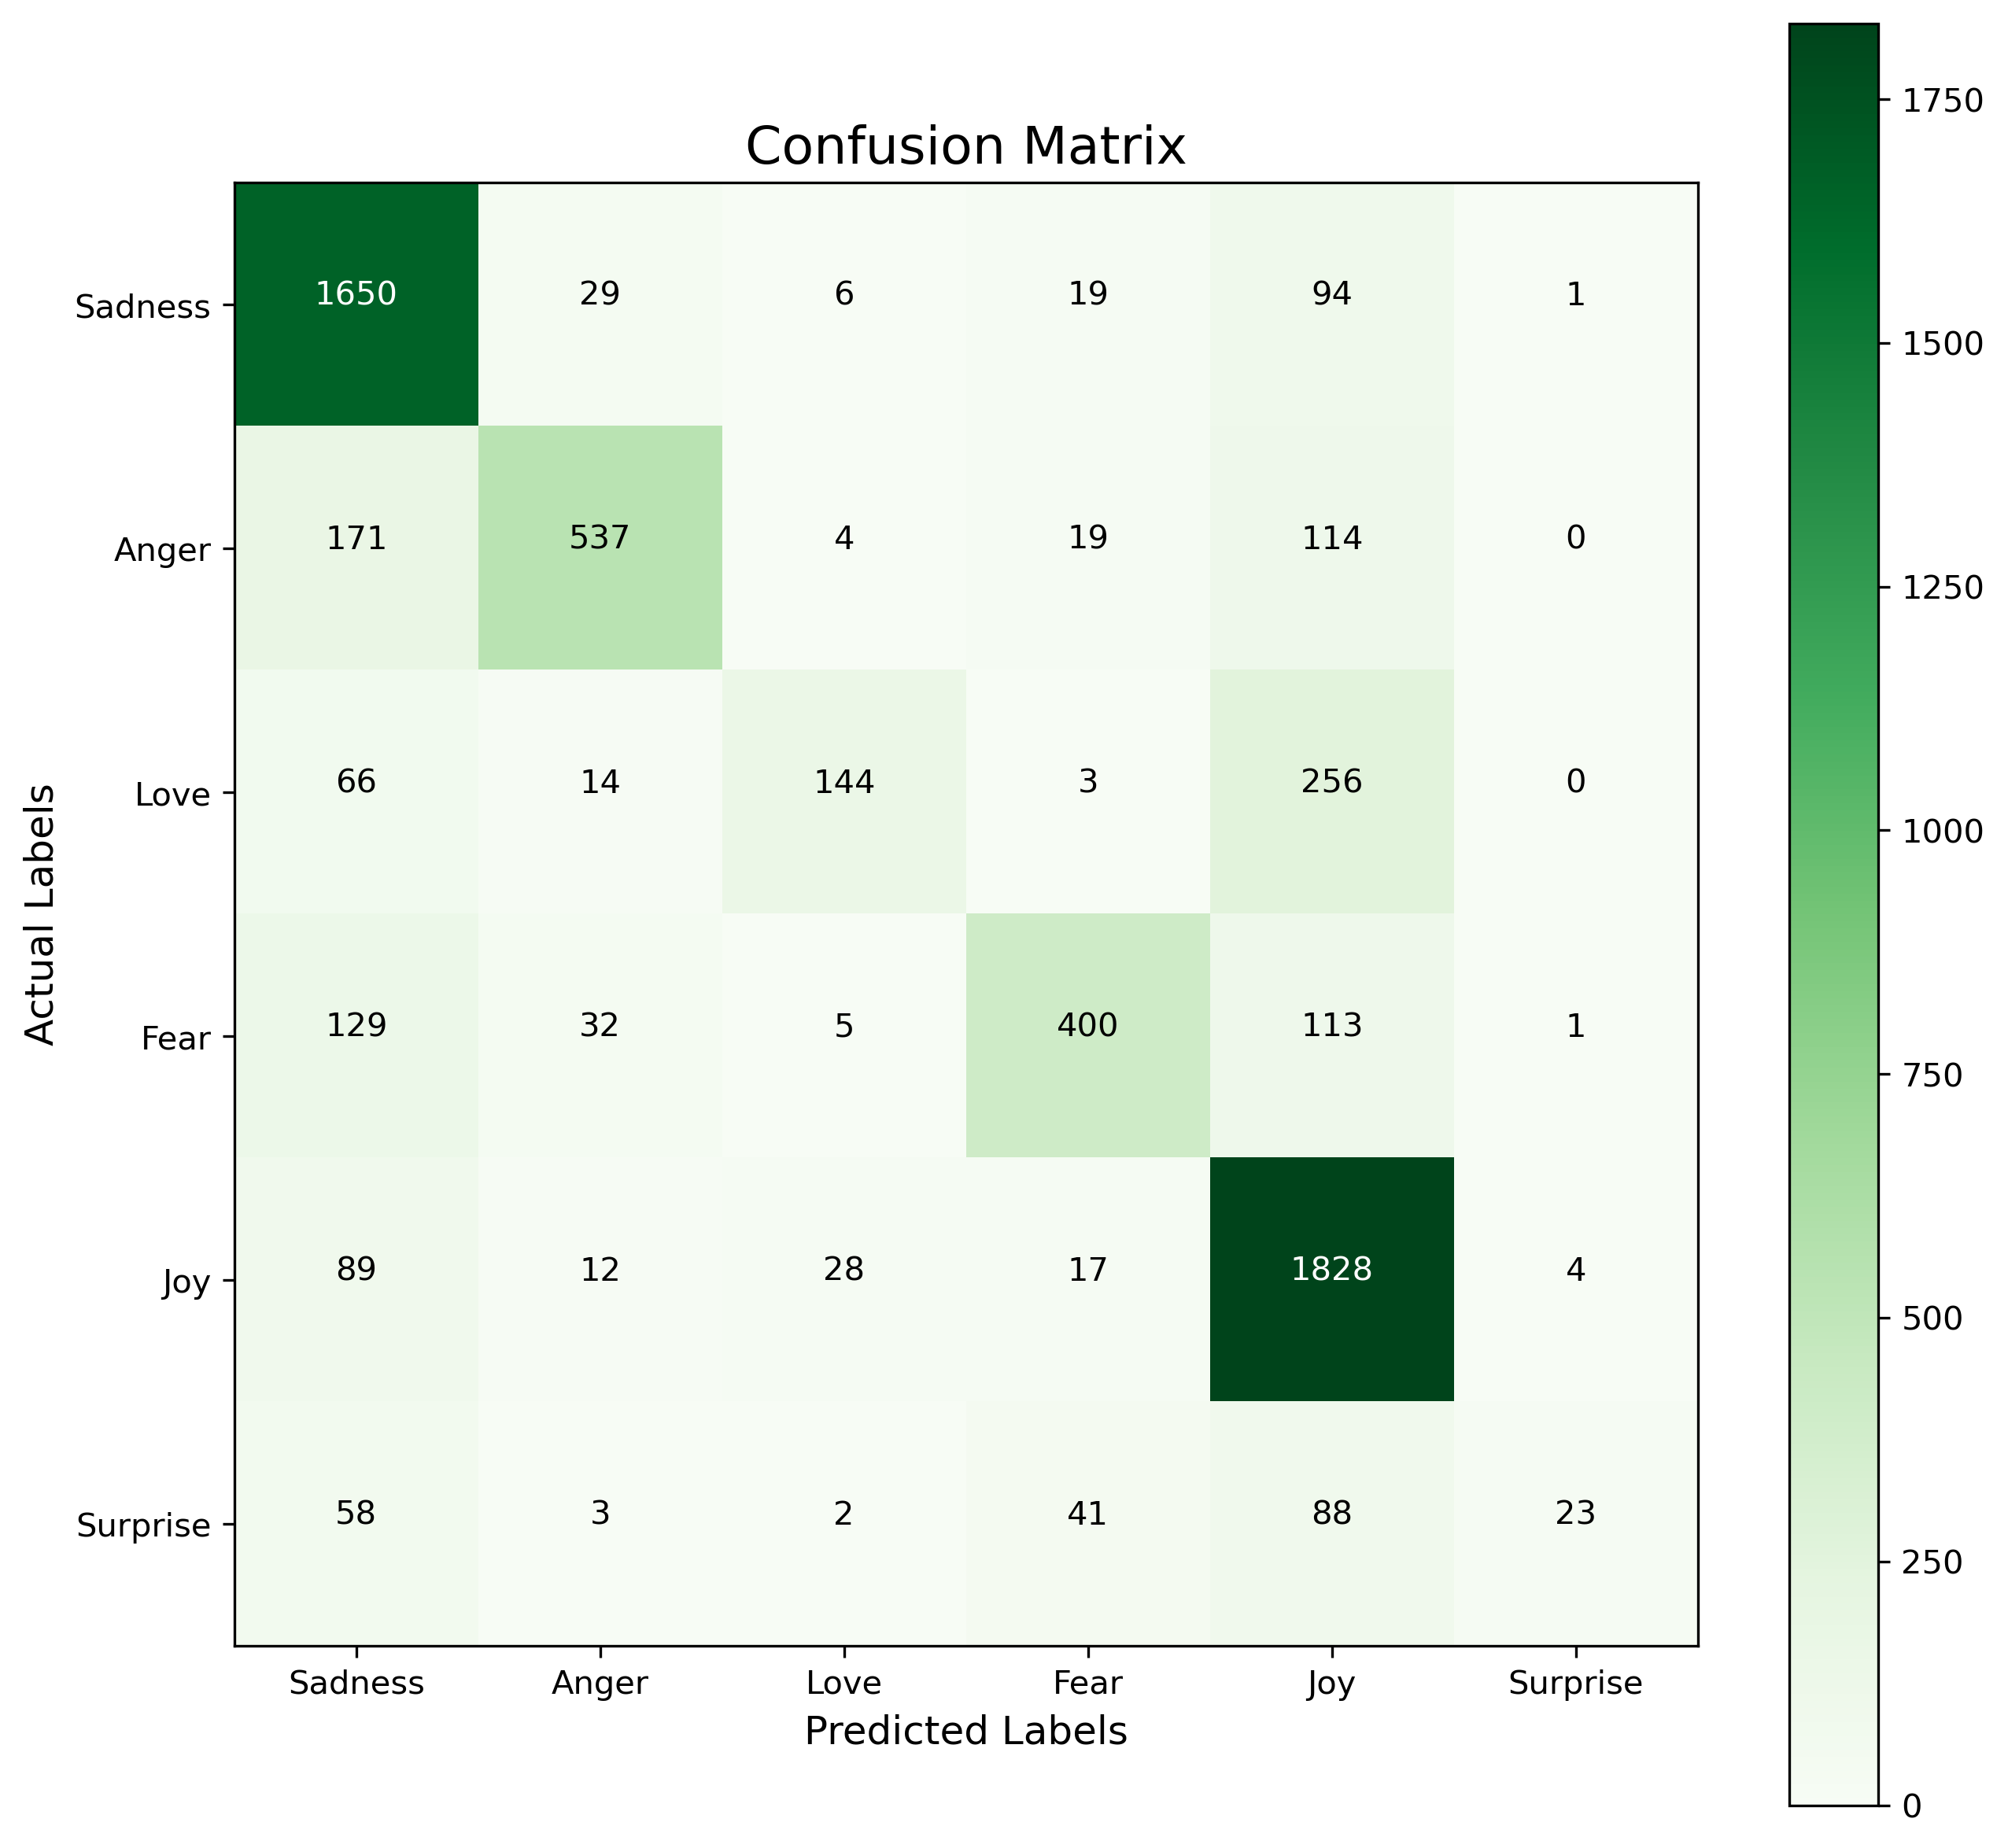

In [243]:
plot_cm(cm,300,LABEL_NAMES)

In [244]:
stats(cm)

('Model recall score is 57.84%',
 'Model precision score is 78.49%',
 'Model f1 score is 66.60%')

In [245]:
matrix=vectorizer.transform(EXAMPLE)

In [246]:
model.predict(matrix)

array([4, 0, 5, 3])

# Train the model using Keras 

In [247]:
TOTAL_INPUTS = X_train.shape[1]

In [248]:
x_val = X_train[:VALIDATION_SIZE]
y_val = y_train[:VALIDATION_SIZE]
x_val.shape

(2000, 11585)

In [249]:
ann = Sequential()
ann.add(Dropout(0.2, seed=101, input_shape=(TOTAL_INPUTS,)))
ann.add(Dense(units=128, activation='relu', name ='ann_hidden1'))
ann.add(Dropout(0.25, seed=101))
ann.add(Dense(units=64, activation='relu', name ='ann_hidden2'))
ann.add(Dense(units=16, activation='relu', name ='ann_hidden3'))
ann.add(Dense(units=10, activation='softmax', name ='m3_output'))

ann.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [250]:
ann.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_5 (Dropout)          (None, 11585)             0         
_________________________________________________________________
ann_hidden1 (Dense)          (None, 128)               1483008   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
ann_hidden2 (Dense)          (None, 64)                8256      
_________________________________________________________________
ann_hidden3 (Dense)          (None, 16)                1040      
_________________________________________________________________
m3_output (Dense)            (None, 10)                170       
Total params: 1,492,474
Trainable params: 1,492,474
Non-trainable params: 0
____________________________________________

In [251]:
samples_per_batch = 1000

In [252]:
nr_epochs = 50
ann_hist = ann.fit(X_train, y_train, 
                   batch_size=samples_per_batch, 
                   epochs=nr_epochs, verbose = 1, 
                   validation_data = [x_val,y_val])

Train on 14000 samples, validate on 2000 samples
Epoch 1/50
14000/14000 [==============================] - 9s 667us/step - loss: 2.2837 - accuracy: 0.2304 - val_loss: 2.2413 - val_accuracy: 0.2650
Epoch 2/50
14000/14000 [==============================] - 10s 708us/step - loss: 2.1594 - accuracy: 0.2856 - val_loss: 2.0540 - val_accuracy: 0.2650
Epoch 3/50
14000/14000 [==============================] - 8s 605us/step - loss: 1.9120 - accuracy: 0.2871 - val_loss: 1.7237 - val_accuracy: 0.2850
Epoch 4/50
14000/14000 [==============================] - 9s 612us/step - loss: 1.5506 - accuracy: 0.5022 - val_loss: 1.2879 - val_accuracy: 0.6700
Epoch 5/50
14000/14000 [==============================] - 9s 609us/step - loss: 1.1692 - accuracy: 0.6649 - val_loss: 0.8906 - val_accuracy: 0.7755
Epoch 6/50
14000/14000 [==============================] - 9s 619us/step - loss: 0.8796 - accuracy: 0.7317 - val_loss: 0.5979 - val_accuracy: 0.8470
Epoch 7/50
14000/14000 [==============================] - 8s 6

In [253]:
ann_hist.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

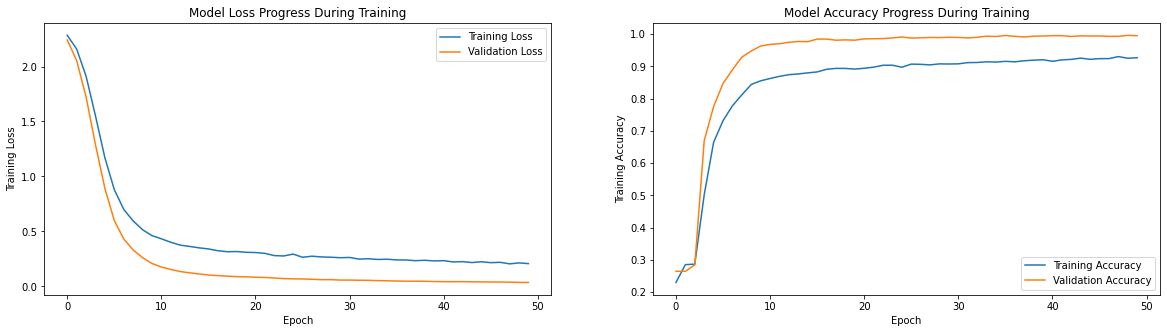

In [254]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(ann_hist.history['loss'])
plt.plot(ann_hist.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Training Loss','Validation Loss'])

plt.subplot(1,2,2)
plt.plot(ann_hist.history['accuracy'])
plt.plot(ann_hist.history['val_accuracy'])
plt.title('Model Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

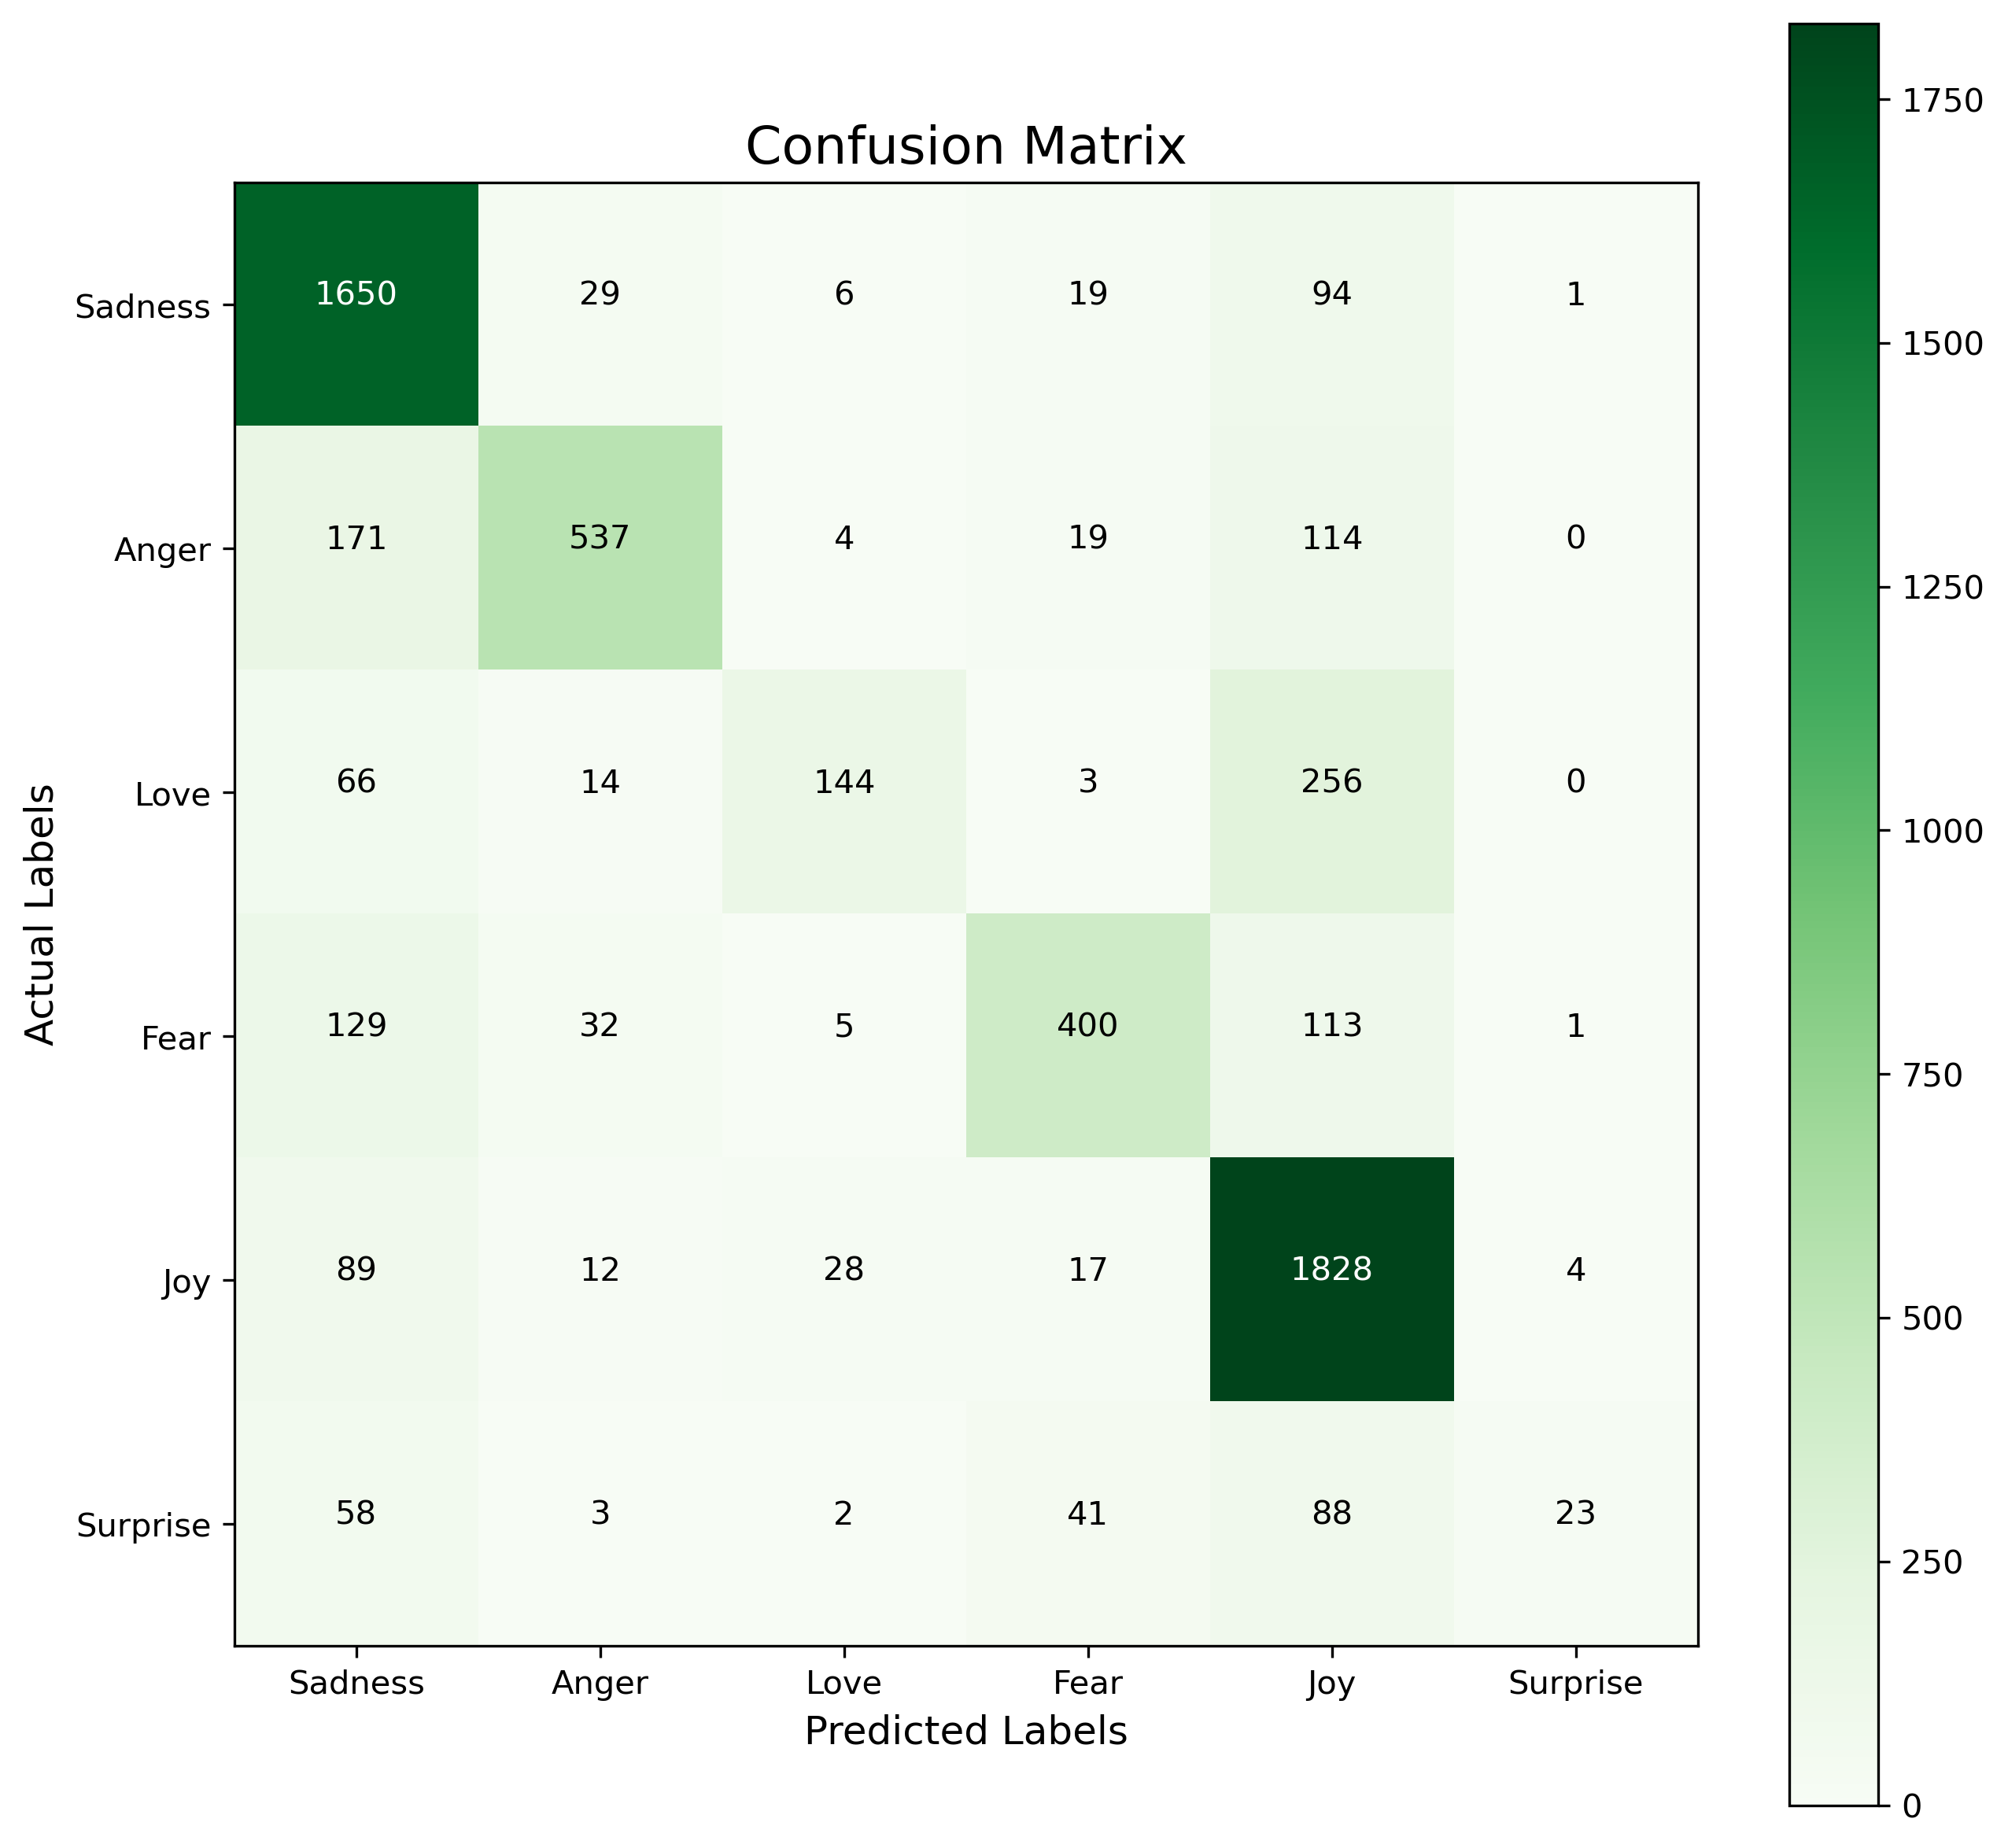

In [255]:
plot_cm(cm,300,LABEL_NAMES)

In [256]:
stats(cm)

('Model recall score is 57.84%',
 'Model precision score is 78.49%',
 'Model f1 score is 66.60%')

In [257]:
matrix=vectorizer.transform(EXAMPLE)

In [258]:
model.predict(matrix)

array([4, 0, 5, 3])